Exp01. 가위바위보 분류하기
=============
---

딥러닝 모델을 통해 가위바위보 이미지 분류기를 만들자.
- TesnsorFlow 표준 API, Keras의 Sequential 분류 모델 활용
- 이미지 데이터 준비 및 전처리 과정
- train, test 데이터셋 분리 및 활용
- 성능 개선 과정


In [1]:
import glob
import os
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

print("import 완료!")

import 완료!


## 1. 데이터 준비 및 전처리
### 1-1. 데이터 수집
- Teachable Machine을 사용하여 직접 가위,바위,보 손 모양 사진 각 100장씩 촬영.
- 내가 만든 데이터 300장으로 training 하고, 다른 교육생의 데이터 300장으로 test시행.
- Train Dataset의 양이 너무 부족하여, 다른 데이터들을 수집하여 5000장 이상 확보.

### 1-2. 데이터 전처리 과정
- 배경 또는 사진이 너무 복잡한 경우 제외하거나 다른 이미지로 대체,
- 다양한 각도로 촬영된 사진 사용. 하지만 손모양 구별이 어려운 사진은 제외,
- 연속 촬영된 사진이 많기 때문에 고려하여 최대한 다양한 사람의 사진을 사용.
- 선별된 2700장의 training data를 이용.

### 1-3. 이미지 크기 변경(28*28)

In [36]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"

ef resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 가위,바위,보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 리사이즈
resize_images(image_dir_path + "/rock")
resize_images(image_dir_path + "/scissor")
resize_images(image_dir_path + "/paper")

print(f"(가로, 세로) = ({img.width}, {img.height})")
img

900  images to be resized.
900  images resized.
900  images to be resized.
900  images resized.
900  images to be resized.
900  images resized.
(가로, 세로) = (28, 28)


### 1-4 이미지 라벨링
- 가위 : 0, 바위 : 1, 보 : 2 으로 모든 이미지에 라벨링을 해줌.
- 0 부터 2699의 인덱스로 각각 label이 지정된 데이터셋이 완성됨.

In [27]:
import numpy as np

def load_data(img_path, number_of_data=2700):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img   
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는", idx,"입니다.")
    return imgs, labels

(x_train, y_train) = load_data(image_dir_path)

이미지 개수는 2700 입니다.


### 1-5 test, validation split하기
- 이미지 데이터인 train 데이터를 정규화해준 후에 데이터 split 시행. 
(한 개의 픽셀이 0 ~ 255 까지의 정보를 가지고 있을 수 있기 때문에 255로 나눠 0~1로 표현.)

In [28]:
# 데이터를 0~1 사이 값으로 정규화(Min-Max Normalization)
x_train_norm = x_train / 255.0

# train, validation data 무작위로 섞어서 나누기 (x_train_norm을 다시 x_train에 넣어주었음.)
x_train, x_val, y_train, y_val = train_test_split(x_train_norm, y_train, test_size=0.2, shuffle=True, random_state=12)

# train, validation data의 사이즈 확인
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(2160, 28, 28, 3) (540, 28, 28, 3) (2160,) (540,)


---
## 2. 모델 설계 및 학습

### 2-1. 모델 설계
- Overfitting 을 피하기 위해 Dropout 레이어 추가.

In [29]:
# 모델 설계
n_channel_1=128
n_channel_2=256
n_dense_1=256
n_dense_2=512

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))  #3개의 클래스로 분류

# 모델 개요 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               1638656   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

### 2-2. 모델 학습
- validation set을 통해 overfitting을 방지.
- val_accrucay가 큰 변화없이 오히려 낮아지려는 지점을 overfitting이 시작되는 구간으로 보고, epochs 수를 조정.
- accuracy loss 값을 history 그래프로 시각화하여 재확인
- 평균적으로 현재 모델에서 epochs=30에서 최적의 성능을 확인.

In [30]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
result = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))


Epoch 1/30
68/68 [==============================] - 1s 8ms/step - loss: 1.0829 - accuracy: 0.3769 - val_loss: 0.9649 - val_accuracy: 0.5148
Epoch 2/30
68/68 [==============================] - 0s 5ms/step - loss: 0.8103 - accuracy: 0.6116 - val_loss: 0.7259 - val_accuracy: 0.6667
Epoch 3/30
68/68 [==============================] - 0s 5ms/step - loss: 0.5080 - accuracy: 0.7787 - val_loss: 0.3957 - val_accuracy: 0.8333
Epoch 4/30
68/68 [==============================] - 0s 5ms/step - loss: 0.3556 - accuracy: 0.8579 - val_loss: 0.3556 - val_accuracy: 0.8333
Epoch 5/30
68/68 [==============================] - 0s 5ms/step - loss: 0.2312 - accuracy: 0.9074 - val_loss: 0.2366 - val_accuracy: 0.9019
Epoch 6/30
68/68 [==============================] - 0s 5ms/step - loss: 0.1912 - accuracy: 0.9315 - val_loss: 0.2177 - val_accuracy: 0.9093
Epoch 7/30
68/68 [==============================] - 0s 5ms/step - loss: 0.1397 - accuracy: 0.9435 - val_loss: 0.1696 - val_accuracy: 0.9241
Epoch 8/30
68/68 [==

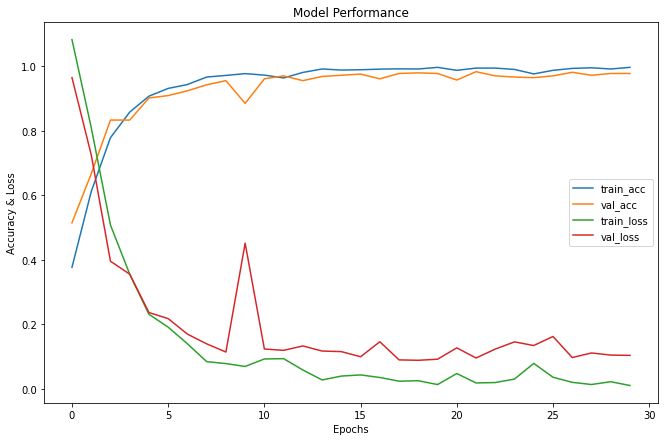

In [32]:
# epochs에 따른 accuracy, loss 값을 그래프로 시각화
plt.figure(figsize=(11, 7))

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='center right')

---
## 3. 성능 평가
### 3-1. Test dataset 준비

In [37]:
# test 데이터가 있는 경로를 변수에 저장
test_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"

resize_images(test_path + "/rock")        #28*28 이미지로 리사이즈하여 저장.
resize_images(test_path + "/scissor")
resize_images(test_path + "/paper")

(x_test, y_test) = load_data(test_path, 300)

# test 데이터 정규화 (Min-Max Normalization)
x_test_norm = x_test / 255.0  

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
이미지 개수는 300 입니다.


### 3-2. test loss와 accuracy

- 모델의 성능 => loss: 1.6050 - accuracy: 0.7367


In [38]:
# loss, accuracy를 통해 model 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

10/10 - 0s - loss: 1.6050 - accuracy: 0.7367


---
## 4. 회고
### 성능 개선 과정
#### Dataset
1. 300개의 데이터에서 시작하여, 900, 1200, 5000장 가까이 늘렸으나, 성능에 도움되지 않는 방해요소가 많아보이는 사진들은 모두 제외하여 2700장으로 선정했다.
2. Dataset에 변화를 주는 것이 실제 성능에서 큰 차이를 보여주었는데, 데이터 수집과 전처리 과정이 중요하다는 것을 알 수 있었다.
3. 모든 데이터를 모아서 그 중 일부를 testset으로 추출하는 식으로 데이터를 나눠줄 경우 성능이 매우 쉽게 상승하는데(accuracy : 0.9이상), 프레임 단위로 촬영된 dataset이기 때문에 사실상 testdata의 족보를 받아서 학습한 것과 같은 것으로 보인다.
4. Image 사이즈를 키우는 것도 정확도 상승에 도움이 되었다. 56x56 으로 시도했을 때 약간의 상승이 있었다.
5. Train dataset을 0.2의 비율로 Validation dataset으로 나누어 학습시켜 overfitting을 피하도록 하였다.

#### Model
1. Dropout을 사용하여 overfitting을 피했다.
2. n1,2 channel과 dense layer의 수를 늘려서 더욱 섬세한 학습을 하도록 하여 정확도 상승에도 확실한 효과가 있었다.

### 덧붙이며
굉장히 단순한 프로젝트임에도 극적인 성능을 낼 수 있도록 하는 일은 상당히 어렵다는 것을 느꼈다. 비슷한 내용의 노드 또는 프로젝트를 마주하게 될 경우를 대비하여 data augmentation과 여러 학습 기법들(Batch Norm, Dropout, Weight initialization, 등...)에 대해 좀 깊이 공부해야함을 느꼈고, 좋은 성능을 위해 이미 어느 정도 좋은 성능을 낼 수 있는 Pretained Model도 다음에 사용해보면 좋을 것 같다.